In [1]:
import os
from functools import partial

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import poisson, norm

Define parameters of the model.

In [2]:
batch_size = 100
learning_rate = 0.005
lambda_lp = 10 # Gradient penalty
lambda_entropy = 5. # Entropy penalty
obs_poisson_rate = 7. # Poisson rate of the observed data
n_observed = 20000 # Number of observed data
prop_initial_mu = np.log(5) # Initial mu of the proposal distribution 
prop_initial_log_sigma = np.log(.3) # Inintial log(sigma) of the proposal distribution
beta1 = 0.5
beta2 = 0.5
dragan_parameter_C = 0.5
critic_steps_1 = 100
critic_steps_2 = 50
early_stopping = 50
count_steps = 3000+1

#For reproducibility 
tf.set_random_seed(2210)
np.random.seed(2210)

In [3]:
def glorot_uniform(fan_in, fan_out, scale=0.1):
    s = scale * np.sqrt(6. / (fan_in + fan_out))
    return np.random.rand(fan_in, fan_out) * 2 * s - s

Generate observed samples and define simulator.

In [4]:
# Generate observed samples
obs_samples = poisson.rvs(obs_poisson_rate,size=n_observed)

# Define simulator
def simulator(X,epsilon=1e-7):
    return poisson.rvs(np.exp(X))+epsilon

Define AVO model.

In [5]:
batch_shape = (None, 1)
critic_shape = (None, 1)

# Placeholder for real distribution
X_real = tf.placeholder(tf.float32,shape=batch_shape)

# Placeholder for simulated distribution
X_sim = tf.placeholder(tf.float32,shape=batch_shape)

# Placeholder for proposal shape
proposal_shape = tf.placeholder(tf.int32,shape=[2])

# Define proposal parameters Psi
with tf.variable_scope('proposal'):
    mu = tf.get_variable('mu', shape=(), initializer=tf.constant_initializer(prop_initial_mu))
    # We use logarithm of sigma since sigma >= 0 in order to stretch it over the real line
    lg_sigma = tf.get_variable('lg_sigma', shape=(), initializer=tf.constant_initializer(prop_initial_log_sigma))

# Define proposal distribution q
prop_distribution = tf.contrib.distributions.Normal(loc=mu, scale=tf.exp(lg_sigma))
sample_proposal = tf.stop_gradient(prop_distribution.sample(sample_shape=proposal_shape))

# Compute the log probability for the parameters 
log_prob_prop = prop_distribution.log_prob(sample_proposal)
#Analytic differential entropy for the proposal distribution
entropy_proposal = lg_sigma 



# Define critic variables
with tf.name_scope('critic'):
    W0 = tf.Variable(glorot_uniform(1,10),dtype=tf.float32,name='W0')
    W1 = tf.Variable(glorot_uniform(10,10),dtype=tf.float32,name='W1')
    W2 = tf.Variable(glorot_uniform(10,1),dtype=tf.float32,name='W2')
    b0 = tf.Variable(np.zeros([1,10]),dtype=tf.float32,name='b0')
    b1 = tf.Variable(np.zeros([1,10]),dtype=tf.float32,name='b1')
    b2 = tf.Variable(np.zeros([1,1]),dtype=tf.float32,name='b2')

# Define the critic
def critic(x):
    h1 = tf.nn.leaky_relu(tf.matmul(x,W0)+b0,alpha=.1)
    h2 = tf.nn.leaky_relu(tf.matmul(h1,W1)+b1,alpha=.1)
    out = tf.matmul(h2,W2)+b2
    return out

# Define perturbed points for LP
X_perturb = tf.concat([X_real,X_sim],axis=0)
u = tf.random_uniform(shape=[tf.shape(X_perturb)[0], 1],minval=-1.,maxval=1.)
_, batch_std = tf.nn.moments(tf.reshape(X_perturb, [-1]), axes=[0])
delta = dragan_parameter_C * batch_std * u
alpha = tf.random_uniform(shape=[tf.shape(X_perturb)[0], 1],minval=0.,maxval=1.)
X_perturb += (1. - alpha) * delta

# Compute critic for different inputs sharing the same variables of the NN:
critic_real = critic(X_real)
critic_sim = critic(X_sim)
critic_perturb = critic(X_perturb)

# LP penalty
gradients = tf.gradients(critic_perturb, [X_perturb])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1))
gradient_penalty = tf.reduce_mean((tf.maximum(0., slopes - 1)) ** 2)

# Define losses
loss_critic = tf.reduce_mean(critic_sim - critic_real)+lambda_lp*gradient_penalty
em = -tf.reduce_mean(critic_sim - critic_real) # Distance between distributions
loss_prop = tf.reduce_mean(-tf.multiply(critic_sim, log_prob_prop) + lambda_entropy*entropy_proposal)

# Define trainable variables
prop_vars = [var for var in tf.trainable_variables() if var.name.startswith('proposal')]
critic_vars = [var for var in tf.trainable_variables() if var.name.startswith('critic')]

# Define optimizers
critic_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='critic', beta1=beta1, beta2=beta2)
prop_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='proposal', beta1=beta1, beta2=beta2)

# Define training operations
train_critic = critic_optimizer.minimize(loss_critic, var_list=critic_vars)
train_proposal = prop_optimizer.minimize(loss_prop, var_list=prop_vars)

# Define variables to reset for critic optimizer
velocity_vars = [critic_optimizer.get_slot(var, 'v') for var in critic_vars]
momentum_vars = [critic_optimizer.get_slot(var, 'm') for var in critic_vars]
reset_vel_mom = tf.variables_initializer(velocity_vars + momentum_vars)

#Reset beta power variables:
reset_b1 = tf.assign(critic_optimizer._beta1_power,beta1)
reset_b2 = tf.assign(critic_optimizer._beta2_power,beta2)
reset_critic = [reset_b1,reset_b2,reset_vel_mom]

#Saver
saver = tf.train.Saver()

Run AVO model to find the parameter distribution.

In [6]:
#Early Stopping parameters
early_stopping_counter = 0
best_em = np.Inf

# Save losses
em_v = np.zeros(count_steps)
loss_d = np.zeros(count_steps)
sd_v = np.zeros(count_steps)
sd_temp = np.zeros(critic_steps_2)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    # Output the current values
    mu_val, lg_sigma_val = sess.run([mu, lg_sigma])
    print('Step 0: mu = {}, sigma = {}'.format(mu_val, np.exp(lg_sigma_val)))

    for epoch in range(count_steps):
        # Reset critic optimizer parameters at each epoch
        sess.run(reset_critic)

        # Optimize critic
        #Small batches
        for idx in range(critic_steps_1):
            x_real = np.random.choice(obs_samples,[batch_size,1])
            thetas = sess.run(sample_proposal,feed_dict={proposal_shape:[batch_size,1]})
            x_sim = simulator(thetas)
            _, this_em = sess.run([train_critic, em],feed_dict={X_real:x_real,X_sim:x_sim})
        #Large batches
        x_real = obs_samples.reshape([-1,1])
        thetas = sess.run(sample_proposal,feed_dict={proposal_shape:[n_observed,1]})
        x_sim = simulator(thetas)
        for idx in range(critic_steps_2):
            _, this_em, this_loss_d = sess.run([train_critic, em,loss_critic],
                                               feed_dict={X_real:x_real,X_sim:x_sim})
            sd_temp[idx] = this_em
        sd_v[epoch] = np.std(sd_temp[-10:])
        # Save loss after optimizing
        em_v[epoch] = this_em
        loss_d[epoch] = this_loss_d

        # Output the current values
        if ((epoch+1) % 10)  == 0:
            mu_val, lg_sigma_val = sess.run([mu, lg_sigma])
            print('Step {}: mu = {}, sigma = {}, em = {}'.format(epoch+1, mu_val, 
                                                                 np.exp(lg_sigma_val), this_em))
        # Update the proposal
        _ = sess.run(train_proposal,feed_dict={X_sim:x_sim,sample_proposal:thetas})
        
        #Check for early stopping
        if this_em < best_em:
            early_stopping_counter = 0
            best_em = this_em
            saver.save(sess,"best_model/best_avo_model.ckpt")
            # Save final values of distribution
            mu_val_best,lg_sigma_val_best = sess.run([mu, lg_sigma])
        else:
            early_stopping_counter = early_stopping_counter + 1
            if early_stopping_counter == early_stopping:
                break

Step 0: mu = 1.6094379425048828, sigma = 0.29999998211860657
Step 10: mu = 1.6544204950332642, sigma = 0.2868002653121948, em = 1.68904709815979
Step 20: mu = 1.7043917179107666, sigma = 0.2728158235549927, em = 1.3643184900283813
Step 30: mu = 1.7543681859970093, sigma = 0.25951188802719116, em = 1.018436312675476
Step 40: mu = 1.8043550252914429, sigma = 0.2468564659357071, em = 0.7929321527481079
Step 50: mu = 1.8542908430099487, sigma = 0.23481911420822144, em = 0.5418020486831665
Step 60: mu = 1.9034109115600586, sigma = 0.22336922585964203, em = 0.35832712054252625
Step 70: mu = 1.9165959358215332, sigma = 0.2124757468700409, em = 0.3242158591747284
Step 80: mu = 1.927213191986084, sigma = 0.20211336016654968, em = 0.2896948754787445
Step 90: mu = 1.9290213584899902, sigma = 0.19225631654262543, em = 0.2720303237438202
Step 100: mu = 1.9268558025360107, sigma = 0.18288010358810425, em = 0.24158398807048798
Step 110: mu = 1.9350212812423706, sigma = 0.17396102845668793, em = 0.209

In [7]:
mu_val_best

1.9492319

In [8]:
np.exp(lg_sigma_val_best)

0.029488411

In [9]:
np.exp(mu_val_best+np.exp(lg_sigma_val_best))

7.2334805

In [10]:
np.exp(mu_val_best-np.exp(lg_sigma_val_best))

6.8192086

In [11]:
np.exp(mu_val)

6.979877

Plot result:

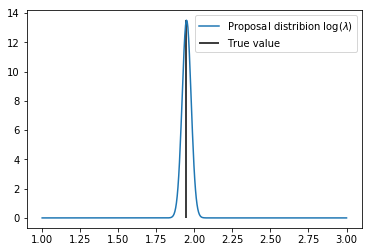

In [12]:
x = np.linspace(1,3,400)
y = norm.pdf(x,mu_val_best,np.exp(lg_sigma_val_best))

plt.plot(x,y,label="Proposal distribion log($\lambda$)")
plt.vlines(np.log(7),0,y.max(), label="True value")
plt.legend()

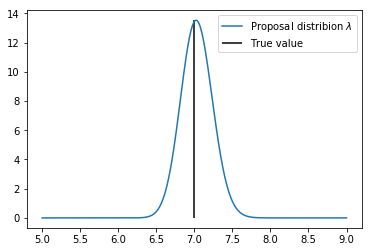

In [13]:
x = np.linspace(5,9,400)
y = norm.pdf(np.log(x),mu_val_best,np.exp(lg_sigma_val_best))

plt.plot(x,y,label="Proposal distribion $\lambda$")
plt.vlines(7,0,y.max(), label="True value")
plt.legend()

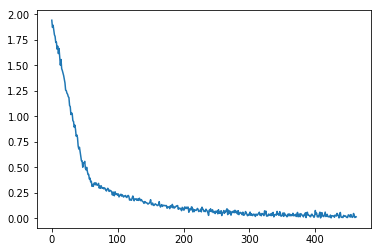

In [14]:
plt.plot(em_v[:epoch-50])

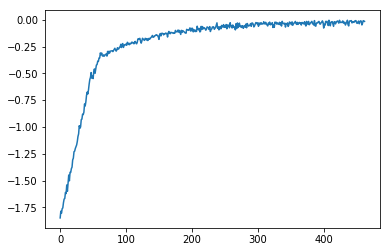

In [15]:
plt.plot(loss_d[:epoch-50])

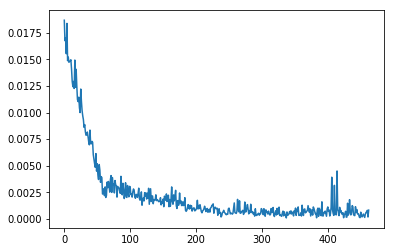

In [16]:
plt.plot(sd_v[:epoch-50])